Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

To complete this project, you should be comfortable working with pandas DataFrames and with using the pandas plot method. You should also have some understanding of hypothesis testing and bootstrap analysis.

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

userid - a unique number that identifies each player.

version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).

sum_gamerounds - the number of game rounds played by the player during the first week after installation

retention_1 - did the player come back and play 1 day after installing?

retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

##AB Testing Process¶

* Understanding business problem & data
* Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
* Look summary stats and plots
* Apply hypothesis testing and check assumptions
* Check Normality & Homogeneity
* Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
* Evaluate the results
* Make inferences
* Recommend business decision to your customer/director/ceo etc.

In [ ]:
#import req libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format


In [ ]:
path = "/content/cookie_cats.csv"

def load(path, info = True):
    
    import pandas as pd
    import io
    
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    return read
    
ab = load(path, info = True)
ab.head()        

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 90189 Column: 5 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 1 
 ['version'] 

Integer Variables: 
 # of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 # of Variables: 2 
 ['retention_1', 'retention_7'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
#Number of Unique Users
print(ab.userid.nunique() == ab.shape[0])

#summary stats: sum_gamer_rounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [ ]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


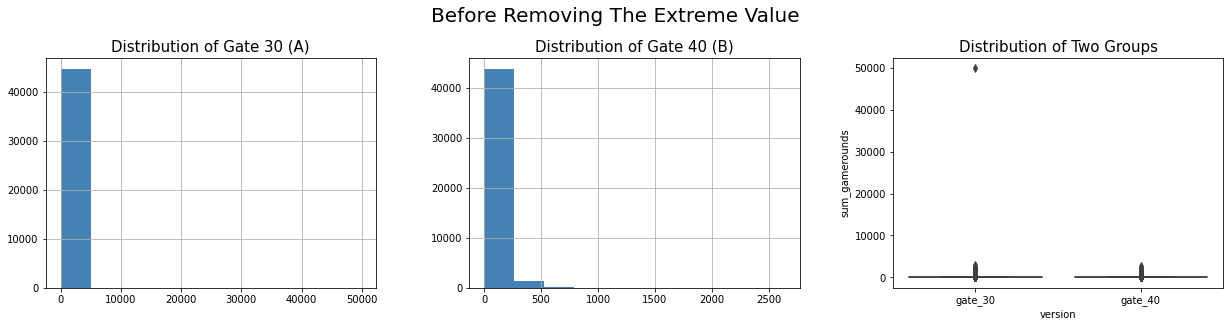

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

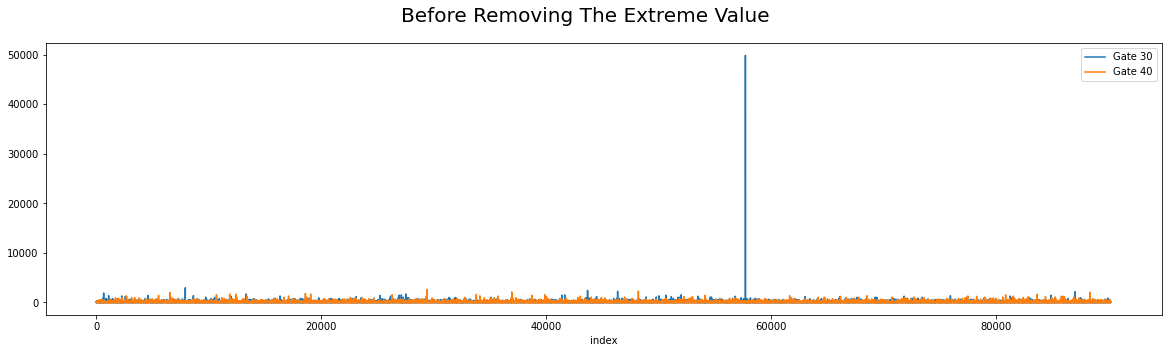

In [ ]:
ab[ab.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

In [ ]:
#outliers
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


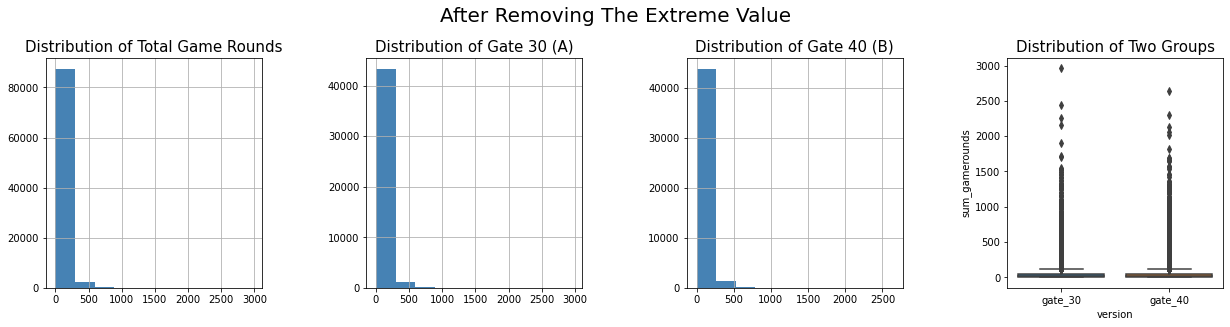

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
ab.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

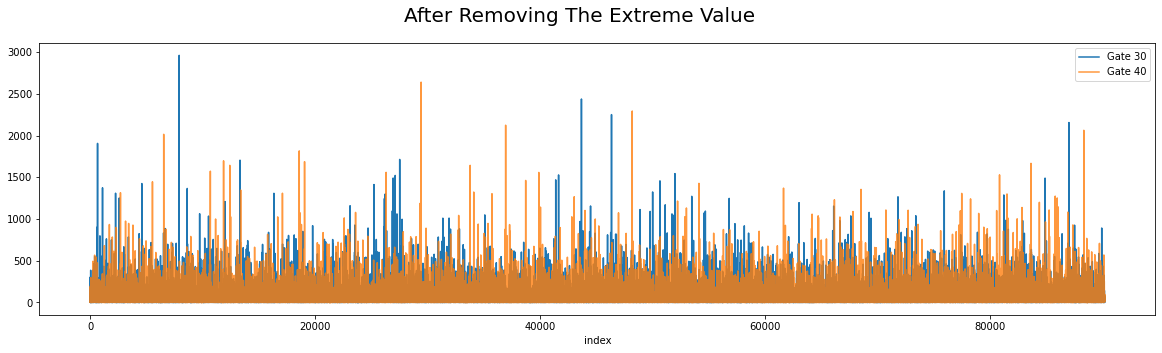

In [ ]:
ab[(ab.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

The users installed the game but 3994 users never played the game! Some reasons might explain this situation.

* They have no free time to play game
* Users might prefer to play other games or they play other games already
* Some users don't like the app etc.
* You can comment below for this users also
* The number of users decreases as the levels progress

Most of users played the game at early stage and they didn't progress.

* Tactile Entertainment should learn why users churn playing the game.
* Doing research and collecting data about the game and users would help to understand user churn
* The difficulty of the game can be measured
* Gifts might help player retention

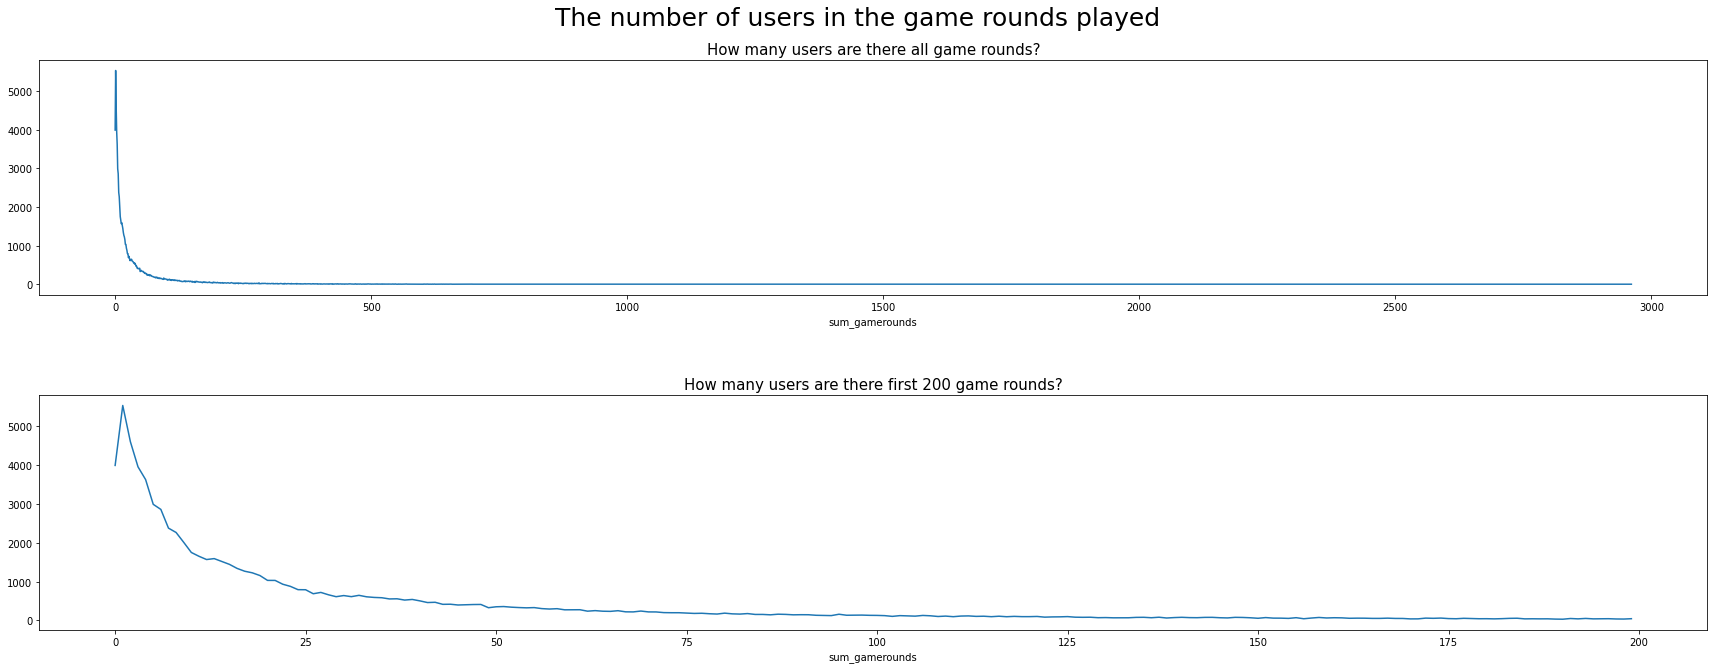

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
ab.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
ab.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

In [ ]:
ab.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [ ]:
# How many users reached gate 30 & gate 40 levels?
ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [ ]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


Retention variables gives us player retention details.

* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?

Also players tend not to play the game! There are many players who quit the game.

* 55 percent of the players didn't play the game 1 day after insalling
* 81 percent of the players didn't play the game 7 day after insalling

In [ ]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": ab["retention_1"].value_counts(),
              "RET7_COUNT": ab["retention_7"].value_counts(),
              "RET1_RATIO": ab["retention_1"].value_counts() / len(ab),
              "RET7_RATIO": ab["retention_7"].value_counts() / len(ab)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


In [ ]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [ ]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

In [ ]:
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0)
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

##A/B Testing

Assumptions:

1. Check normality
2. If Normal Distribution, check homogeneity

Steps:
* Split & Define Control Group & Test Group
* Apply Shapiro Test for normality
* If parametric apply Levene Test for homogeneity of variances
* If Parametric + homogeneity of variances apply T-Test
* If Parametric - homogeneity of variances apply Welch Test
* If Non-parametric apply Mann Whitney U Test directly

In [ ]:
# Define A/B groups
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,A,3,False,False,0
1,337,A,38,True,False,0
2,377,B,165,True,False,0
3,483,B,1,False,False,0
4,488,B,179,True,True,1


In [ ]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp


# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.0509,A/B groups are similar!
